In [20]:
# from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import IPython.display as ipd

In [21]:
input_dir = '../data/01_raw/Indian/Arijit Singh/'
filename = 'Duaa.mp3'

In [22]:
ipd.Audio(f'{input_dir}{filename}')

In [23]:
y, sr = librosa.load(f'{input_dir}{filename}', duration=480)

/Users/abap778/anaconda3/envs/kedro_geet_env/lib/python3.6/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


In [24]:
y

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [25]:
sr

22050

In [26]:
# And compute the spectrogram magnitude and phase
S_full, phase = librosa.magphase(librosa.stft(y))

In [27]:
S_full

array([[0.0000000e+00, 0.0000000e+00, 1.5044855e-05, ..., 1.1805197e-01,
        8.2413420e-02, 4.7451463e-02],
       [0.0000000e+00, 0.0000000e+00, 1.5038284e-05, ..., 1.1462451e-01,
        3.0469395e-02, 6.4608365e-02],
       [0.0000000e+00, 0.0000000e+00, 1.5018189e-05, ..., 2.5933206e-01,
        2.1329726e-01, 9.4501480e-02],
       ...,
       [0.0000000e+00, 0.0000000e+00, 3.1153611e-08, ..., 1.6093620e-06,
        8.8608749e-07, 3.0033743e-07],
       [0.0000000e+00, 0.0000000e+00, 3.0418825e-08, ..., 1.1862649e-06,
        1.4876149e-07, 2.5109614e-07],
       [0.0000000e+00, 0.0000000e+00, 3.0171130e-08, ..., 1.1876806e-06,
        5.8491929e-07, 2.2283535e-07]], dtype=float32)

In [28]:
phase

array([[ 1.        +0.0000000e+00j,  1.        +0.0000000e+00j,
        -1.        +1.5099580e-07j, ...,  1.        +0.0000000e+00j,
         1.        +0.0000000e+00j,  1.        +0.0000000e+00j],
       [ 1.        +0.0000000e+00j,  1.        +0.0000000e+00j,
        -0.9807573 -1.9523084e-01j, ..., -0.8569348 -5.1542485e-01j,
        -0.6388224 +7.6935428e-01j, -0.42902678-9.0329176e-01j],
       [ 1.        +0.0000000e+00j,  1.        +0.0000000e+00j,
        -0.92366767-3.8319448e-01j, ...,  0.66174304+7.4973071e-01j,
         0.15709357-9.8758370e-01j, -0.90381867+4.2791560e-01j],
       ...,
       [ 1.        +0.0000000e+00j,  1.        +0.0000000e+00j,
         0.90087956-4.3406913e-01j, ...,  0.73896945-6.7373896e-01j,
        -0.2580841 +9.6612245e-01j, -0.5081104 -8.6129194e-01j],
       [ 1.        +0.0000000e+00j,  1.        +0.0000000e+00j,
         0.97489876-2.2264862e-01j, ..., -0.92281216+3.8525015e-01j,
         0.20010932+9.7977358e-01j, -0.55748445+8.3018738e-01j]

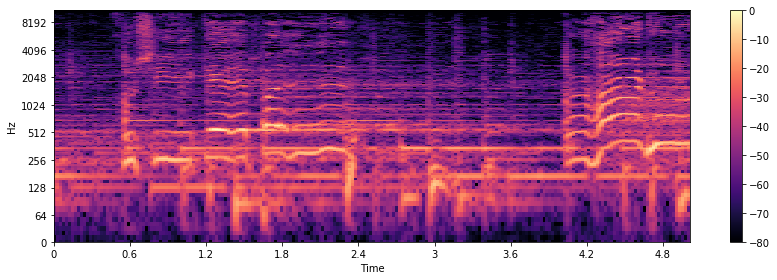

In [29]:
idx = slice(*librosa.time_to_frames([30, 35], sr=sr))
plt.figure(figsize=(12, 4))
librosa.display.specshow(librosa.amplitude_to_db(S_full[:, idx], ref=np.max),
                         y_axis='log', x_axis='time', sr=sr)
plt.colorbar()
plt.tight_layout()

In [30]:
# We'll compare frames using cosine similarity, and aggregate similar frames
# by taking their (per-frequency) median value.
#
# To avoid being biased by local continuity, we constrain similar frames to be
# separated by at least 2 seconds.
#
# This suppresses sparse/non-repetetitive deviations from the average spectrum,
# and works well to discard vocal elements.

S_filter = librosa.decompose.nn_filter(S_full,
                                       aggregate=np.median,
                                       metric='cosine',
                                       width=int(librosa.time_to_frames(2, sr=sr)))

# The output of the filter shouldn't be greater than the input
# if we assume signals are additive.  Taking the pointwise minimium
# with the input spectrum forces this.
S_filter = np.minimum(S_full, S_filter)

In [31]:
# Note: the margins need not be equal for foreground and background separation
margin_i, margin_v = 2, 10
power = 2

mask_i = librosa.util.softmask(S_filter,
                               margin_i * (S_full - S_filter),
                               power=power)

mask_v = librosa.util.softmask(S_full - S_filter,
                               margin_v * S_filter,
                               power=power)

# Once we have the masks, simply multiply them with the input spectrum
# to separate the components

S_foreground = mask_v * S_full
S_background = mask_i * S_full

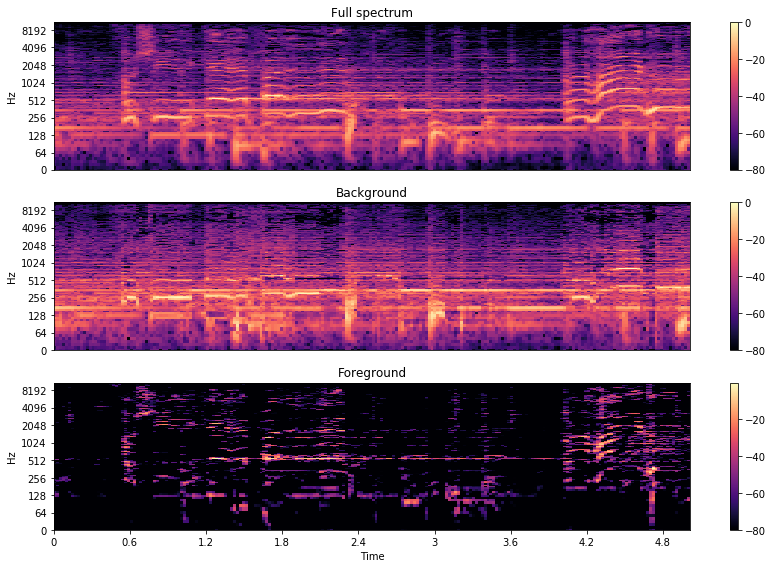

In [32]:
# sphinx_gallery_thumbnail_number = 2

plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
librosa.display.specshow(librosa.amplitude_to_db(S_full[:, idx], ref=np.max),
                         y_axis='log', sr=sr)
plt.title('Full spectrum')
plt.colorbar()

plt.subplot(3, 1, 2)
librosa.display.specshow(librosa.amplitude_to_db(S_background[:, idx], ref=np.max),
                         y_axis='log', sr=sr)
plt.title('Background')
plt.colorbar()
plt.subplot(3, 1, 3)
librosa.display.specshow(librosa.amplitude_to_db(S_foreground[:, idx], ref=np.max),
                         y_axis='log', x_axis='time', sr=sr)
plt.title('Foreground')
plt.colorbar()
plt.tight_layout()
plt.show()

In [39]:
S_foreground[:, idx]

array([[0.0000000e+00, 5.4239663e-05, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 6.7456113e-04],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 5.0757430e-06,
        0.0000000e+00, 0.0000000e+00],
       [1.0778132e-07, 1.2414890e-08, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [8.3606079e-07, 0.0000000e+00, 6.9435956e-08, ..., 2.6943582e-05,
        0.0000000e+00, 0.0000000e+00]], dtype=float32)

In [38]:
ipd.Audio(data=S_foreground, rate=sr)

In [41]:
librosa.output.write_wav('test.wav', S_foreground, sr)

In [42]:
librosa.output.write_wav('test_2.wav', S_background, sr)